<a href="https://colab.research.google.com/github/stefkim/loan_prediction/blob/main/Loan_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [79]:
train = pd.read_csv('/content/drive/MyDrive/loan_prediction/train.csv')

In [80]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [72]:
missing_values_total = train.isnull().sum().sort_values(ascending=False)
missing_values_pct = (train.isnull().mean()*100).sort_values(ascending=False)

missing_values = pd.concat([missing_values_total, missing_values_pct, train.dtypes],
                           keys=['Total','Percentage','Dtype'],
                           axis=1)
missing_values.head(10)

,Total,Percentage,Dtype
Credit_History,50,8.143322,float64
Self_Employed,32,5.211726,object
LoanAmount,22,3.583062,float64
Dependents,15,2.442997,object
Loan_Amount_Term,14,2.280130,float64
Gender,13,2.117264,object
Married,3,0.488599,object
Loan_Status,0,0.000000,object
Property_Area,0,0.000000,object
CoapplicantIncome,0,0.000000,float64


In [73]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


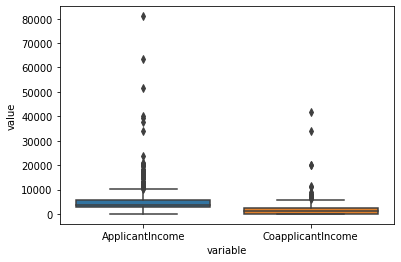

In [90]:
sns.boxplot(x="variable", y="value", data=pd.melt(train[['ApplicantIncome','CoapplicantIncome']]))

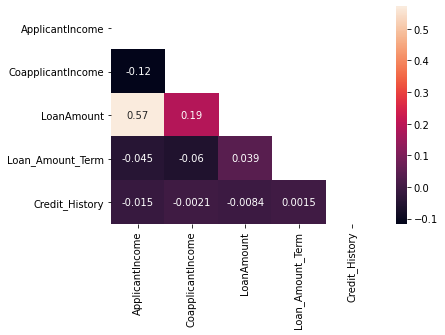

In [76]:
matrix = np.triu(train.corr())
sns.heatmap(train.corr(), annot=True, mask=matrix)

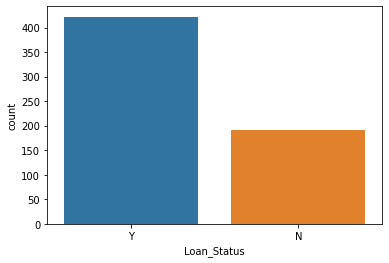

In [108]:
sns.countplot(train['Loan_Status'])

In [81]:
df = train.copy()
df.drop(columns='Loan_ID',inplace=True)

In [82]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
np.random.seed(99)
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: le.fit_transform(x.astype(str)))

In [83]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,NaN,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


In [84]:
y = df['Loan_Status']
X = df.drop(columns='Loan_Status')

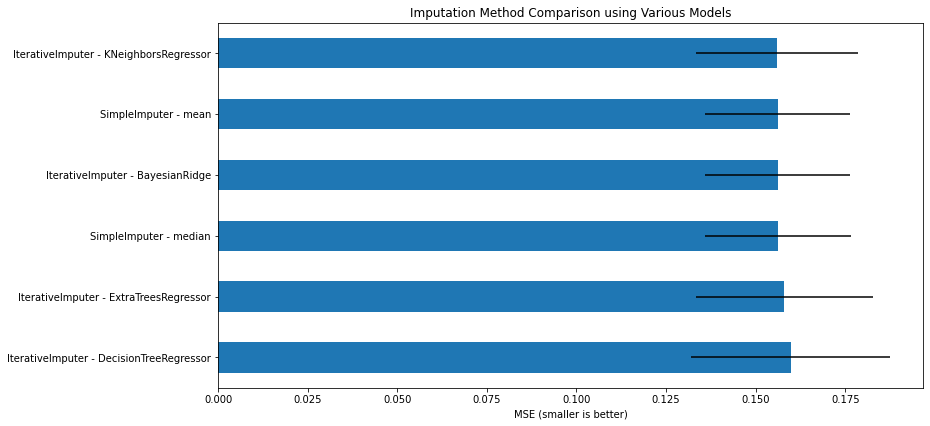

In [97]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor


df_y = df['Loan_Status']
df_X = df.drop(columns='Loan_Status')

N_SPLITS = 5
br_estimator = BayesianRidge()

np.random.seed(1772023)

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        StandardScaler(),
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, df_X, df_y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

# Neigbors
nn = round(np.sqrt(12))

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=nn)
]

score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        StandardScaler(),
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, df_X, df_y, scoring='neg_mean_squared_error',
            cv=N_SPLITS
    )

scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)

# plot results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean().sort_values()
errors = scores.std().sort_values()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('Imputation Method Comparison using Various Models')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" - ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [98]:
-scores.mean().sort_values(ascending=False)

IterativeImputer  KNeighborsRegressor      0.156014
SimpleImputer     mean                     0.156093
IterativeImputer  BayesianRidge            0.156171
SimpleImputer     median                   0.156250
IterativeImputer  ExtraTreesRegressor      0.157984
                  DecisionTreeRegressor    0.159727
dtype: float64

In [99]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

np.random.seed(1772023)
X_imp = imputer.fit_transform(X)

In [100]:
X_imp

array([[  1.,   0.,   0., ..., 360.,   1.,   2.],
       [  1.,   1.,   1., ..., 360.,   1.,   0.],
       [  1.,   1.,   0., ..., 360.,   1.,   2.],
       ...,
       [  1.,   1.,   1., ..., 360.,   1.,   2.],
       [  1.,   1.,   2., ..., 360.,   1.,   2.],
       [  0.,   0.,   0., ..., 360.,   0.,   1.]])

In [101]:
from sklearn.preprocessing import StandardScaler
np.random.seed(1772023)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=1772023)

In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


cv = StratifiedKFold(n_splits=5, random_state=1772023, shuffle=True)
rf = RandomForestClassifier()
lr = LogisticRegression()

In [105]:
scores = pd.DataFrame()
np.random.seed(1772023)
for scoring in ['accuracy','f1','roc_auc']:
    scores[scoring] = cross_val_score(rf,
                                      X_train, 
                                      y_train,
                                      scoring=scoring,
                                      cv=cv, n_jobs=-1)
scores.mean()

accuracy    0.784783
f1          0.866636
roc_auc     0.724983
dtype: float64

In [109]:
scores = pd.DataFrame()
np.random.seed(1772023)
for scoring in ['accuracy','f1','roc_auc']:
    scores[scoring] = cross_val_score(lr,
                                      X_train,
                                      y_train,
                                      scoring=scoring,
                                      cv=cv, n_jobs=-1)
scores.mean()

accuracy    0.802174
f1          0.872024
roc_auc     0.719812
dtype: float64

In [112]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(k_neighbors=2)
np.random.seed(1772023)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

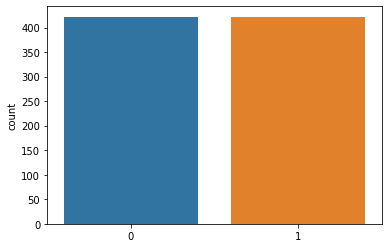

In [113]:
sns.countplot(y_smote)

In [114]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_smote, 
                                                                y_smote, 
                                                                test_size=0.25, 
                                                                random_state=1772023)

In [115]:
scores = pd.DataFrame()
np.random.seed(1772023)
for scoring in ['accuracy','f1','roc_auc']:
    scores[scoring] = cross_val_score(rf, 
                                      X_train_sm, 
                                      y_train_sm, 
                                      scoring=scoring, 
                                      cv=cv, n_jobs=-1)
scores.mean()

accuracy    0.815086
f1          0.804528
roc_auc     0.886482
dtype: float64

In [116]:
scores = pd.DataFrame()
np.random.seed(1772023)
for scoring in ['accuracy','f1','roc_auc']:
    scores[scoring] = cross_val_score(lr,
                                      X_train_sm,
                                      y_train_sm, 
                                      scoring=scoring, 
                                      cv=cv, n_jobs=-1)
scores.mean()

accuracy    0.673003
f1          0.725512
roc_auc     0.706720
dtype: float64

In [119]:
! cwd /content/drive/MyDrive/loan_prediction

/bin/bash: cwd: command not found


In [118]:
!pwd

/content
